# Integrating External Knowledge using Logic Tensor Networks

In this example, we want to use logic tensor networks (LTNs) to train a simple "character" recognizer without direct labels, but instead using knowledge about how the "characters" are constructed.

In a first step, we need to setup the environmnent. You need to install:
    
   * tensorflow
   * pillow
   * pandas
   * matplotlib
    
Furthermore, you need to download the LTN project from here: https://github.com/logictensornetworks/logictensornetworks

Then, you need to enable Python to find the LTN implementation. You can do this by providing the path to where you downloaded the LTN implementation in the following cell.

In [1]:
import sys
sys.path.append('logictensornetworks/')
%matplotlib inline

In [2]:
import itertools
import ltn
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import re
import tensorflow as tf

/Users/wesflo/micromamba/envs/xaai/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
tf.keras.utils.set_random_seed(42)

## Dataset

In the following, we will load the dataset. Download the dataset from Canvas and provide the appropriate paths to the `load_data()` function.

In [5]:
def load_data(root_path, img_file, take=1000, train_ratio=0.8, batch_size=16):
    data = pd.read_csv(img_file)
    classes = data['char'].unique()
    per_class = take // len(classes)
    
    data = data.sample(frac=1)
    paths = [os.path.join(root_path, img)
              for cls in classes 
              for img in data[data['char'] == cls]['image'][:per_class]]
    np.random.shuffle(paths)
    train_idx = int(len(paths) * train_ratio)
    
    train_paths = paths[:train_idx]
    test_paths = paths[train_idx:]
    train_imgs = [np.array(Image.open(f)) for f in train_paths]
    test_imgs = [np.array(Image.open(f)) for f in test_paths]
    
    ds_train = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(train_idx).batch(batch_size)
    ds_test = tf.data.Dataset.from_tensor_slices(test_imgs).shuffle(train_idx).batch(batch_size)
    
    return ds_train, ds_test, train_paths, test_paths

In [6]:
ds_train, ds_test, train_paths, test_paths = load_data('dataset/char/', 'dataset/char/dataset.csv')

As you can see in the following cell, our "characters" consists of two geometric shapes - one on top of the other. The geometric shapes are either a triangle, a rectangle or a hexagon. Your task will be to recognize the character by making use of the knowledge about which shapes correspond to which character.

Therefore, we will need one recognizer for the whole character and one recognizer for the upper or lower part.

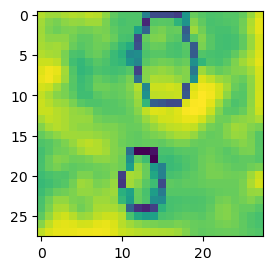

In [7]:
x = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:])

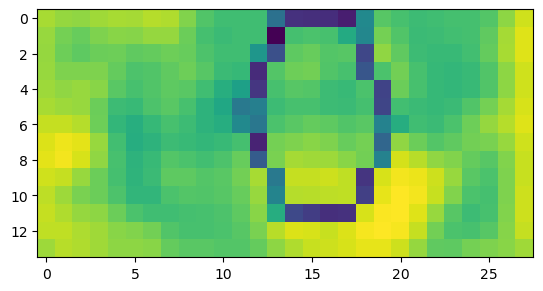

In [8]:
plt.imshow(x[0][:14,:])

## LTN - Learning with Shape Lables
### Problem Setup

The two networks defined in the next cell will be used to recognize the "characters" (`char_model`) and geometric shapes (`part_model`) respectively.

In [9]:
char_num = 9
part_num = 3

char_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Reshape((28, 28, 1)),
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(char_num),
    ]
)

part_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(14, 28)),
        tf.keras.layers.Reshape((14, 28, 1)),
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(part_num),
    ]
)

The code in the next few cells pre-trains the shape recognizer and freezes the recongizers

In [10]:
def augment(image, rng):
    img = Image.fromarray(image)
    select = rng.integers(0, 2, size=2)
    angle = 0
    translate = (0, 0)
    if select[0]:
        angle = rng.integers(0, 20) - 10
    if select[1]:
        translate = tuple(rng.integers(0, 10, size=2) - 5)
        
    img = img.rotate(angle, translate=translate)
    return np.array(img)
        
def part_generator(paths, epochs, steps_per_epoch, imgs_per_part):
   
    batch_size = 8
    batches = epochs * steps_per_epoch
    label_map = {'3': [1, 0, 0], '4': [0, 1, 0], '6': [0, 0, 1]}
    rng = np.random.default_rng()
    
    images = []
    labels = []
    for cls in label_map:
        matcher = re.compile(f'.*_{cls}_\d+.png')    
        all_paths = [path for path in paths if matcher.match(path)]
        imgs_per_part = min(imgs_per_part, len(all_paths))
        images += [np.array(Image.open(f))[14:, :] for f in all_paths[:imgs_per_part]]
        labels += [label_map[cls] for _ in range(imgs_per_part)]
    
    print(len(images))
    for i in range(batches):
        selected = rng.integers(0, len(labels), size=batch_size)
        inputs = [augment(images[f], rng) for f in selected]
        targets = [labels[f] for f in selected]
        
        yield np.array(inputs), np.array(targets).reshape(1, -1, 3) 

In [11]:
outputs = tf.keras.layers.Softmax()(part_model.outputs)
pre_model = tf.keras.models.Model(inputs=part_model.inputs, 
                                  outputs=outputs)

In [12]:
pre_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pre_model.fit(part_generator(train_paths, 5, 1000, 10), verbose=True, epochs=5, steps_per_epoch=1000)

30
Epoch 1/5


2025-04-07 12:13:32.970086: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1000/1000 [==============================] - 2s 2ms/step - loss: 0.7676 - accuracy: 0.6490
Epoch 2/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2378 - accuracy: 0.9131
Epoch 3/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1095 - accuracy: 0.9645
Epoch 4/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9841
Epoch 5/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0396 - accuracy: 0.9900


In [13]:
part_model.trainable = False

In the following three cells, we setup different constructs required for the LTN:
    
   * two predicates, $Char$ and $Part$, which evaluate to True if the given image contains the passed character/shape
   * three variables representing a character $c \in Chars$ or shapes $p1, p2 \in Parts$ respectively
   * required logic conjunctions and quantifiers
   * the knowledge base, which encodes which character is made of which shapes
   * a predicate implementation for the $Composed$ predicate, which evaluates to True if the given combination of character, upper shape, and lower shape are valid, i.e., the character is composed of the upper shape and the lower shape in their respective position

In [14]:
Char = ltn.Predicate.FromLogits(char_model, activation_function="softmax")
Part = ltn.Predicate.FromLogits(part_model, activation_function="softmax")

c = ltn.Variable("char", range(char_num))
p1 = ltn.Variable("part1", range(part_num))
p2 = ltn.Variable("part2", range(part_num))

And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

In [15]:
parts = [3, 4, 6]
chars = itertools.product(range(len(parts)), repeat=2)
knowledge_base = [[i, c[0], c[1]] for i, c in enumerate(chars)]
knowledge_base = np.array(knowledge_base)

In [16]:
class tf_ComposeModel(tf.keras.Model):
    """ Model checking composition."""
    def __init__(self, knowledge_base):
        super(tf_ComposeModel, self).__init__()
        # encode composition: 100 for char, 10 for part1 and 1 for part2 
        self.kb = (knowledge_base * np.array([100, 10, 1])).sum(axis=1)
    
    def call(self, inputs):
        char = tf.math.multiply(inputs[0], 100)
        part1 = tf.math.multiply(inputs[1], 10)
        part2 = inputs[2]
        
        encoded = tf.math.add_n([char, part1, part2])
        locations = []
        # find each valid combination of char and its parts
        for pattern in self.kb:
            locations.append(tf.math.equal(encoded, pattern))
            
        # combine locations into one Boolean vector of valid locations
        locations = tf.concat(locations, axis=-1)
        locations = tf.math.reduce_any(locations, axis=1)
        
        return tf.expand_dims(locations, axis=-1)

$$
    \mathbf{D}(upper) = \mathbf{D}(lower) = \mathbf{D}(x) = images \\
    \mathbf{D}(c) = characters \\
    \mathbf{D}(p1) = \mathbf{D}(p2) = parts \\
    \forall Diag(x, upper, lower) (\exists c, p1, p2: Composed(c, p1, p2) (Char(x, c) \land (Part(upper, p1) \land Part(lower, p2))))
$$

The idea here is that for every character (and its upper and lower part), there is a label configuration, so that the configuration conforms to the specification of a character and the character and shape recognition models recognize the given images as those labels.

In [17]:
Composed = ltn.Predicate(tf_ComposeModel(knowledge_base))

### Axioms
@tf.function
def axioms(images_x, p_schedule=tf.constant(2.)):   
    images_upper = ltn.Variable("upper", images_x[:, :14, :])
    images_lower = ltn.Variable("lower", images_x[:, 14:, :])
    images_x = ltn.Variable("x", images_x)
    axiom = Forall(
            ltn.diag(images_x,images_upper,images_lower),
            Exists(
                (c, p1, p2),
                And(Char([images_x, c]), And(Part([images_upper, p1]), Part([images_lower, p2]))),
                mask=Composed([c, p1, p2]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

images_x = next(ds_train.as_numpy_iterator())
axioms(images_x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(), dtype=float32, numpy=0.035419285>

### Training

Run the following four cells to train the LTN to satisfy the defined logic formula for the training dataset.

In [18]:
optimizer = tf.keras.optimizers.legacy.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
}

@tf.function
def train_step(images_x, **parameters):
    # loss
    with tf.GradientTape(persistent=True) as tape:
        loss = 1.- axioms(images_x, **parameters)
    # train Char model
    gradients = tape.gradient(loss, char_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, char_model.trainable_variables))
    # train Part model
    gradients = tape.gradient(loss, part_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, part_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    
@tf.function
def test_step(images_x, **parameters):
    # loss
    loss = 1.- axioms(images_x, **parameters)
    metrics_dict['test_loss'](loss)

In [19]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}

In [20]:
def run_training(epochs, metrics_dict, ds_train, ds_test, train_step, test_step, scheduled_parameters):
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label

    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        print(template.format(epoch,*metrics_results))

In [21]:
run_training(20, metrics_dict, ds_train, ds_test, train_step, test_step, scheduled_parameters)

Epoch 0, train_loss: 0.9836, test_loss: 0.9825
Epoch 1, train_loss: 0.9820, test_loss: 0.9818
Epoch 2, train_loss: 0.9811, test_loss: 0.9816
Epoch 3, train_loss: 0.9804, test_loss: 0.9794
Epoch 4, train_loss: 0.9291, test_loss: 0.9141
Epoch 5, train_loss: 0.8923, test_loss: 0.8749
Epoch 6, train_loss: 0.8572, test_loss: 0.8503
Epoch 7, train_loss: 0.8353, test_loss: 0.8354
Epoch 8, train_loss: 0.6831, test_loss: 0.6758
Epoch 9, train_loss: 0.5769, test_loss: 0.5728
Epoch 10, train_loss: 0.5251, test_loss: 0.5386
Epoch 11, train_loss: 0.4997, test_loss: 0.5201
Epoch 12, train_loss: 0.3910, test_loss: 0.4526
Epoch 13, train_loss: 0.3861, test_loss: 0.4070
Epoch 14, train_loss: 0.3751, test_loss: 0.4168
Epoch 15, train_loss: 0.3706, test_loss: 0.3991
Epoch 16, train_loss: 0.3633, test_loss: 0.3940
Epoch 17, train_loss: 0.3610, test_loss: 0.4070
Epoch 18, train_loss: 0.3582, test_loss: 0.3935
Epoch 19, train_loss: 0.3557, test_loss: 0.3958


### Evaluation

Run the following four cells to evaluate the character and shape recognizer you trained.

In [22]:
def char_test_generator(paths):
    batch_size = 8
    classes = 9
    images = []
    labels = []
    
    batches = len(paths) // batch_size
    matcher = re.compile('.*/(\d+)_.*')
    for idx in range(batches * batch_size):
        cls = int(matcher.match(paths[idx]).group(1))
        label = np.zeros(classes)
        label[cls] = 1
        images.append(np.array(Image.open(paths[idx])))
        labels.append(label)
    
    print(len(images))
    for i in range(batches):
        
        inputs = np.array(images[i*batch_size:i*batch_size+batch_size])
        targets = np.array(labels[i*batch_size:i*batch_size+batch_size])
        
        yield inputs, targets

In [23]:
def part_test_generator(paths):
   
    label_map = {'3': [1, 0, 0], '4': [0, 1, 0], '6': [0, 0, 1]}
    
    images = []
    labels = []
    for cls in label_map:
        matcher = re.compile(f'.*_{cls}_\d+.png')    
        all_paths = [path for path in paths if matcher.match(path)]
        images += [np.array(Image.open(f))[14:, :] for f in all_paths]
        labels += [label_map[cls] for _ in range(len(all_paths))]
    
    print(len(images))
    for i in range(len(images)):
        
        inputs = [images[i], ]
        targets = [labels[i], ]
        
        yield np.array(inputs), np.array(targets)

In [24]:
char_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
char_model.evaluate(char_test_generator(test_paths))

200
25/25 [==============================] - 0s 12ms/step - loss: 16.1181 - accuracy: 0.9550


[16.118101119995117, 0.9549999833106995]

In [25]:
part_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
part_model.evaluate(part_test_generator(test_paths))

200
200/200 [==============================] - 0s 462us/step - loss: 16.1181 - accuracy: 1.0000


[16.118104934692383, 1.0]

This seems to have worked

Answer:


In [26]:
char_model.predict(x)

1/1 [==============================] - 0s 57ms/step


array([[-19.693026  ,  -1.5858269 ,  -0.07433618,  -7.2484393 ,
         -3.3232288 , -19.381233  ,   1.1944746 , -19.735638  ,
          6.4469485 ],
       [-19.4268    ,  -1.5819961 ,   2.02067   ,  -7.997442  ,
         -2.1281664 , -19.185059  ,  -0.72229445, -20.147104  ,
          6.2504387 ],
       [-21.651619  ,  -3.6677306 ,  -5.2301826 ,  -2.9248674 ,
         10.248312  , -22.286419  ,  -6.5144978 , -23.209558  ,
          1.8260115 ],
       [-19.286932  ,   1.6308165 ,   9.919362  ,  -8.062005  ,
         -5.1428814 , -19.231297  ,  -4.6453295 , -19.589241  ,
          3.424105  ],
       [-27.18326   , -21.453712  ,  -4.452263  ,  20.379269  ,
          2.6558025 , -27.002762  ,   8.907864  , -28.130135  ,
         -4.087888  ],
       [-18.700819  ,  -5.8746195 ,   1.3617517 ,   1.8814801 ,
         -7.16964   , -19.30423   ,   8.163996  , -19.169516  ,
         -0.04736719],
       [-14.766735  , -14.756649  ,  -3.4811707 ,   7.9288974 ,
         -2.5106158 , -16.0088

In [27]:
part_model.predict(x[:, :14, :])

1/1 [==============================] - 0s 43ms/step


array([[ -8.29894   ,  -7.9976745 ,   9.440104  ],
       [ -5.4170046 ,  -6.245299  ,   6.1623726 ],
       [ -6.270904  ,   2.7126946 ,  -0.8493959 ],
       [  6.7757936 ,  -9.875167  ,  -0.4820165 ],
       [-20.929508  ,  15.98288   ,  -1.4555466 ],
       [ -1.7687993 ,  -5.146667  ,   3.1067939 ],
       [ -6.3869295 ,   6.383285  ,  -2.502199  ],
       [-14.177123  ,  11.756243  ,  -4.881053  ],
       [ -7.9724364 ,  -9.928202  ,   9.478032  ],
       [ -3.633059  ,  -7.813391  ,   5.463474  ],
       [  4.247868  ,  -7.531877  ,   0.5446832 ],
       [  5.086492  ,  -9.599037  ,   0.25852382],
       [ -1.4952985 ,  -1.0523641 ,  -0.8512151 ],
       [ -2.9517884 ,  -6.907682  ,   5.9165564 ],
       [ -6.736693  ,  -8.6614895 ,   8.420139  ],
       [  6.054859  ,  -9.029182  ,  -1.3561293 ]], dtype=float32)

In [28]:
part_model.predict(x[:, 14:, :])

1/1 [==============================] - 0s 16ms/step


array([[ -3.8688955 ,  -3.790211  ,   2.3156433 ],
       [ -2.4926853 ,  -6.999678  ,   4.5770445 ],
       [-12.839831  ,   9.514938  ,  -1.9163997 ],
       [ -3.2059755 ,  -4.671968  ,   4.0203648 ],
       [  7.206024  , -10.568068  ,  -0.783634  ],
       [  4.874892  ,  -7.711306  ,  -0.34918147],
       [  6.824925  , -10.856482  ,   0.08742601],
       [  6.1062407 ,  -9.623889  ,  -0.19288541],
       [ -5.1261697 ,  -8.290001  ,   7.1412973 ],
       [  4.3119445 ,  -8.68934   ,  -0.10405929],
       [ -3.2771306 , -11.790586  ,   7.279767  ],
       [ -5.5403876 ,  -8.891624  ,   7.160758  ],
       [  4.797151  ,  -6.880939  ,  -1.2053545 ],
       [ -2.0719514 ,  -7.516393  ,   4.0704155 ],
       [  4.5525126 ,  -9.260526  ,   0.22648524],
       [ -3.1526313 ,  -0.07601392,   0.06208235]], dtype=float32)

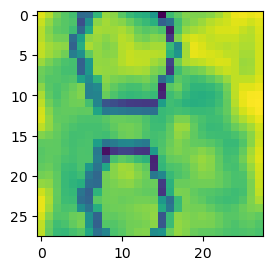

In [29]:
plt.subplot(121)
plt.imshow(x[1][:,:])

In [30]:
knowledge_base

array([[0, 0, 0],
       [1, 0, 1],
       [2, 0, 2],
       [3, 1, 0],
       [4, 1, 1],
       [5, 1, 2],
       [6, 2, 0],
       [7, 2, 1],
       [8, 2, 2]])